In [23]:
import numpy as np
# from surfinpy import chemical_potential_plot
from surfinpy import utils as ut
from scipy.interpolate import CubicSpline
import yaml
import sys
np.set_printoptions(threshold=1000)

colmap = ['#5B9BD5', '#4472C4', '#A5A5A5', '#772C24', '#ED7D31', '#FFC000', '#70AD47','#255E91', '#99ffcc']

In [2]:
def calculate_normalisation(phase, bulk, bulk_zpe, bulk_svib,
                            data_zpe, data_svib, temperature):
    r"""Normalises the phase energy relative to the bulk material.
    Thus allowing the different phase calculations to be compared.
    TO DO rewrite 
    .. math::
        Energy = \frac{1}{2A} \Bigg( E_{MO}^{slab} -
        \frac{nCat_{slab}}{nCat_{Bulk}} E_{MO}^{Bulk} \Bigg)

    where Energy is the slab energy normalised to the
    bulk, :math:`E_{MO}^{slab}` is the DFT slab energy, :math:`nCat_{slab}`
     is the number of slab cations, :math:`nCat_{Bulk}` is the number of bulk
    cations, :math:`E_{MO}^{Bulk}` is the DFT bulk energy A is the surface
    area.

    TO DO Rewrite

    Parameters
    ----------
    slab_energy : float
        Energy of the slab from DFT
    slab_cations : int
        Total number of cations in the slab
    bulk : dictionary
        Dictionary of bulk properties
    area : float
        Surface area

    Returns
    -------
    float:
        Constant normalising the slab energy to the bulk energy.
    """
    # Calculating Energy of reaction  =  Ephase - EMgO

    try:
        Phase_units = phase['F-Units']
    except KeyError:
        Phase_units = 0
    
  
    return ((phase['Energy'] + (data_zpe * Phase_units) - temperature * data_svib * Phase_units) - (phase['Cation'] / bulk['Cation'])
            * ((bulk['Energy'] / bulk['F-Units'])- temperature * bulk_svib))


In [3]:
def calculate_surface_energy(deltamux, deltamuy, x_energy, y_energy,
                             phase, normalised_bulk):
    r"""Calculates the surface for a given chemical potential of
    species x and species y for a single phase.

    .. math::
        \gamma_{Surf} = \frac{1}{2S} \Bigg( E_{MO}^{slab} -
        \frac{nCat_{Slab}}{nCat_{Bulk}} E_{MO}^{Bulk} \Bigg) -
         \Gamma_O \mu_O - \Gamma_{H_2O} \mu_{H_2O} -
         \Gamma_O  \mu_O (T) - \Gamma_{H_2O} \mu_{H_2O} (T)

    where S is the surface area, :math:`E_{MO}^{slab}` is the DFT energy of
    the stoichiometric slab, :math:`nCat_{Slab}` is the number of cations
    in the slab, :math:`nCat_{Slab}` is the number of cations in the bulk
    unit cell, :math:`E_{MO}^{Bulk}` is the DFT energy of the bulk unit cell,
    :math:`\Gamma_O`  :math:`\Gamma_{H_2O}` is the excess oxygen / water at
    the surface and :math:`\mu_O` :math:`\mu_{H_2O}` is the oxygen /
    water chemcial potential.

    Parameters
    ----------
    deltamux : array like
        Chemical potential of species x
    deltamuy : array like
        Chemical potential of species y
    x_energy : float
        DFT energy or temperature corrected DFT energy
    y_energy : float
        DFT energy or temperature corrected DFT energy
    xexcess : float
        Surface excess of species x
    yexcess : float
        Surface excess of species y
    normalised_bulk : float
        Slab energy normalised to the bulk value.

    Returns
    -------
    array like:
        2D array of surface energies as a function of
        chemical potential of x and y
    """

    return (
        normalised_bulk - deltamux* phase['X'] - deltamuy* phase['Y'] - (
        x_energy * phase['X']) - (y_energy * phase['Y']))

In [4]:
def evaluate_phases(data, bulk, x, y, nphases, x_energy, y_energy, Entropy_true=False, ZPE_true=False, temp_range=0, temperature = 0):
    """Calculates the surface energies of each phase as a function of chemical
    potential of x and y. Then uses this data to evaluate which phase is most
    stable at that x/y chemical potential cross section.

    Parameters
    ----------
    data : list
        List containing the dictionaries for each phase
    bulk : dictionary
        dictionary containing data for bulk
    x : dictionary
        X axis chemical potential values
    y : dictionary
        Y axis chemical potential values
    nsurfaces : int
        Number of phases
    x_energy : float
        DFT 0K energy for species x
    y_energy : float
        DFT 0K energy for species y

    Returns
    -------
    phase_data  : array like
        array of ints, with each int corresponding to a phase.
    """
    xnew = ut.build_xgrid(x, y)
    ynew = ut.build_ygrid(x, y)
    S = np.array([])
    bulk_zpe = bulk_svib = data_zpe = data_svib = 0
    
    
    if Entropy_true==True or ZPE_true==True:
        bulk_zpe, bulk_svib = Vib_Calc(bulk['File-Name'], temp_range, ZPE_true, Entropy_true)
        temperature = temp_range['Range'][0]
    
    for k in range(0, nphases):
        if Entropy_true==True or ZPE_true==True:
            data_zpe, data_svib = Vib_Calc(data[k]['File-Name'], temp_range, ZPE_true, Entropy_true)  

            
        normalised_bulk = calculate_normalisation(data[k], bulk, bulk_zpe, bulk_svib,
                                                  data_zpe, data_svib, temperature
                                                   )
        SE = calculate_surface_energy(xnew, ynew, 
                                      x_energy,
                                      y_energy,
                                      data[k],
                                      normalised_bulk)
        S = np.append(S, SE)

    phase_data, SE = ut.get_phase_data(S, nphases)
    return phase_data, SE

In [5]:
def temperature_correction(nist_file, temperature):
    """Use experimental data to correct the DFT free energy of an adsorbing
    species to a specific temperature.

    Parameters
    ----------
    nist_file : array like
        numpy array containing experiemntal data from NIST_JANAF
    temperature : int
        Temperature to correct to

    Returns
    -------
    gibbs : float
        correct free energy
    """
    nist_data = ut.read_nist(nist_file)
    
    h0 = nist_data[0, 4]
    fitted_s = fit(nist_data[:, 0], nist_data[:, 2], np.arange(1, 3000))
    fitted_h = fit(nist_data[:, 0], nist_data[:, 4], np.arange(1, 3000))

    fitted_h = fitted_h - fitted_h[0]
    
    gibbs = calculate_gibbs(np.arange(1, 3000), fitted_s, fitted_h)

    return gibbs[(temperature)-1]

In [6]:
def fit(x, y, t):
    '''Fit a polynominal function to thermochemical data from NIST_JANAF

    Parameters
    ----------
    x : array like
        x axis for fit
    y : array like
        y axis for fit
    t : array like
        x axis to be fitted

    Returns
    -------
    shift : array like
        data fitted from x and y to t
    '''
#     z = np.polyfit(x, y, 3)
#     f = np.poly1d(z)
    
    cs = CubicSpline(x, y, bc_type='clamped')

    shift = cs(t)
    

    
#     shift = f(t)

    return shift


In [7]:

def calculate_gibbs(t, s, h):
    '''Calculate the gibbs free energy from thermochemcial data
    obtained from the NIST_JANAF database

    Parameters
    ----------
    t : array like
        Temperature range
    s : array like
        delta s values from nist
    h : array like
        selta h values from nist

    Returns
    -------
    g : array like
        gibbs energy as a function of temperature
    '''

    deltas = (s * 0.01036) / 1000
    deltah = h  * 0.01036
    g = deltah - t * deltas

    return g


In [8]:
def calculate(data, bulk, deltaX, deltaY, x_energy, y_energy, Entropy_true=False, ZPE_true=False, temp_range=0,
              temperature=0, output="Phase_Diagram.png"):
    """Initialise the surface energy calculation.

    Parameters
    ----------
    data : list
        List of dictionaries for each phase
    bulk : dictionary
        Dictionary containing data for bulk
    deltaX : dictionary
        Range of chemical potential/label for species X 
    DeltaY : dictionary
        Range of chemical potential/label for species Y 
    x_energy : float
        DFT energy of adsorbing species
    y_energy : float
        DFT energy of adsorbing species
    temperature : int
        Temperature
    output : str
        Output file name

    Returns
    -------
    system : class obj
        Plotting object
    """
    data = sorted(data, key=lambda k: (k['Y']))
    nphases = len(data)

    X = np.arange(deltaX['Range'][0], deltaX['Range'][1],
                  0.005, dtype="float")
    Y = np.arange(deltaY['Range'][0], deltaY['Range'][1],
                  0.005, dtype="float")  

    phases, SE = evaluate_phases(data, bulk, X, Y,
                             nphases, x_energy, y_energy, Entropy_true, ZPE_true, temp_range, temperature)
#     ticks = np.unique([phases])

#     phases = ut.transform_numbers(phases, ticks)

#     Z = np.reshape(phases, (Y.size, X.size))
#     labels = ut.get_labels(ticks, data)

#     system = chemical_potential_plot.ChemicalPotentialPlot(X,
#                                                            Y,
#                                                            Z,
#                                                            labels,
#                                                            ticks,
#                                                            deltaX['Label'],
#                                                            deltaY['Label'])
    
    
    ticks = np.unique([phases])
    c = []
    for k in range(0,ticks.size):
        c.append(colmap[ticks[k]-1])


#     phases = ut.transform_numbers(phases, ticks)

    Z = np.reshape(phases, (Y.size, X.size))
    
#     labels = ut.get_labels(ticks, data)
    labels = []
    for i in range(0, ticks.size):
        val = ticks[i] - 1
        val = int(val)
        label = data[val]['Label']
        labels.append(label)


    system = ChemicalPotentialPlot(X,Y,Z,labels,
                                   ticks,deltaX['Label'],deltaY['Label'],c)

#     print(type(phases))

    import pandas
    df = pandas.DataFrame(Z, columns=X, index=Y)
    df.to_csv('file.csv')    
    
    return system,c

# Vibrational Properties Utils

In [9]:
def read_vibdata(vib_file):
#Read Data 
    with open(vib_file, 'r') as file:
        vib_prop = yaml.load(file)
    return vib_prop

In [10]:
def build_tempgrid(z, y):
    """Builds a 2D grip of values for the x axis.

    Parameters
    ----------
    x : array like
        numpy array
    y : array like
        numpy array

    Returns
    -------
    xnew : array like
        numpy array
    """
    znews = np.tile(z, len(y))
    znews = np.reshape(znews, (len(z), len(y)), order='F')


    return znews

In [11]:
def build_freqgrid(z, y):
    """Builds a 2D grip of values for the x axis.

    Parameters
    ----------
    x : array like
        numpy array
    y : array like
        numpy array

    Returns
    -------
    xnew : array like
        numpy array
    """
    znews = np.tile(z, (len(y),1))

    return znews

In [12]:
def ZPE_Calc(vib_prop):
# Zero Point Energy Calc

# hc = h * c * 0.5 unit cmJ
# 1.6021E-19 j to eV conversion

    hc = 9.93247898996E-24

    vib_prop_1 = list(map(lambda x : x * hc, vib_prop['Frequencies']))
    zpe = sum(vib_prop_1)
    zpe = zpe / 1.6021E-19 / vib_prop['F-Units']

    
    return zpe


In [13]:
def Entropy_Calc(freq, temp, vib_prop):
# Entropy Calc
    hc = 1.99E-25 *100.0E0
    k = 1.38064852E-23
    R=8.314
    np.seterr(over='ignore')


    Theta = np.multiply(freq,hc)
    Theta = np.divide(Theta, k)

    u = np.multiply(Theta, R)/(np.exp(np.divide(Theta, temp), dtype=np.float64)-1)
    uvib = np.sum(u, axis=1)
    uvib = uvib/vib_prop['F-Units'] 

    a = np.multiply(Theta, R)*np.log(1-np.exp(np.negative(np.divide(Theta, temp)), dtype=np.float64))
    avib = np.sum(a, axis=1)
    avid = avib/vib_prop['F-Units'] 

    s = np.divide(np.subtract(u,a), temp)
    svib = np.sum(s, axis=1, dtype=np.float64)
    svib = svib/vib_prop['F-Units'] 

    svib = np.divide(svib,96485)
    
    return svib

In [14]:
def Vib_Calc(vib_file, temp_range, zpe_true, ent_true):
    temp_r = np.arange(temp_range['Range'][0], temp_range['Range'][1],
                      1, dtype="int")
    
    vib_prop = read_vibdata(vib_file)
    
    new_temp = build_tempgrid(temp_r, vib_prop['Frequencies']) 
    freq = build_freqgrid(vib_prop['Frequencies'], temp_r) 
    
    zpe = 0
    if zpe_true==True:
        zpe = ZPE_Calc(vib_prop)
    if ent_true==True:
        svib = Entropy_Calc(freq, new_temp, vib_prop)
       
    return(zpe, svib)

# Plot

In [76]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from surfinpy import utils as ut

class ChemicalPotentialPlot:
    """Class that plots a phase diagram as a function of chemical potential.

    Parameters
    ----------
    x : array like
        x axis, chemical potential of species x
    y : array like
        y axis, chemical potential of species y
    z : array like
        two dimensional grid, phase info
    labels : list
        list of phase labels
    ticks : list
        list of phases
    xlabel : str
        species name for x axis label
    ylabel : str
        species name for y axis label
    """
    def __init__(self, x, y, z, labels, ticks, xlabel, ylabel,c):
        self.x = x
        self.y = y
        self.z = z
        self.labels = labels
        self.ticks = ticks
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.c = c

    def plot_phase(self, temperature=None, xlabel=None, ylabel=None, output="phase.png", 
                   colourmap="viridis", set_style="default", figsize=None, show_fig=True):
        """Plots a simple phase diagram as a function of chemical potential.

        Parameters
        ----------
        temperature: int (optional)
            Temperature. Default=None
        xlabel: str (optional)
            Set a custom x-axis label. Default=None
        ylabel: str (optional)
            Set a custom y-axis label. Default=None
        output: str (optional)
            Output filename. Default='phase.png'
            If output is set to `None`, no output is generated.
        colourmap: str (optional)
            Colourmap for the plot. Default='viridis'
        figsize: tuple (optional)
            Set a custom figure size. Default=None
        show_fig: bool (optional)
            Automatically display a figure. Default=True
            If set to False the plot is returned as an object.
        """
        if set_style:
            plt.style.use(set_style)
        levels = ut.get_levels(self.z)
        ticky = ut.get_ticks(self.ticks)
        temperature_label = str(temperature) + " K"
        if xlabel:
            XLab = xlabel
        else:
            XLab = "$\Delta \mu_{\mathrm{" + self.xlabel + "}}$" + " (eV)"
        if ylabel:
            YLab = ylabel
        else:
            YLab = "$\Delta \mu_{\mathrm{" + self.ylabel + "}}$" + " (eV)"
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        CM = ax.contourf(self.x, self.y, self.z, levels=levels, cmap=colourmap)
        ax.set_ylabel(YLab, fontsize=14)
        ax.set_xlabel(XLab, fontsize=14)
        if temperature:
            ax.text(0.1, 0.95, temperature_label,  fontsize=15, color="white",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)
        ax.tick_params(labelsize=12)
        cbar = fig.colorbar(CM, ticks=ticky, pad=0.1)
        cbar.ax.set_yticklabels(self.labels)
        plt.tight_layout()
        if output:
            plt.savefig(output, dpi=600)
        if show_fig:
            plt.show()
        else:
            return ax

    def plot_mu_p(self, temperature, output="phase.png", colourmap="viridis",
                  set_style="default"):
        """ Plots a phase diagram  with two sets of axis, one as a function of
        chemical potential and the second is as a function of pressure.

        Parameters
        ----------
        temperature : int (optional)
            temperature
        output : str (optional)
            output filename
        colourmap : str
            colourmap for the plot
        """
        if set_style:
            plt.style.use(set_style)
        p1 = ut.pressure(self.x, temperature)
        p2 = ut.pressure(self.y, temperature)
        temperature_label = str(temperature) + " K"
        levels = [0, *self.ticks]
        ticky = np.subtract(levels,0.5)
        X1Lab = "$\Delta \mu_{\mathrm{" + self.xlabel + "}}$" + " (eV)"
        Y1Lab = "$\Delta \mu_{\mathrm{" + self.ylabel + "}}$" + " (eV)"
        X2Lab = "$P_" + "{\mathrm{" + self.xlabel + "}}$" + str(temperature) + " K (bar)"
        Y2Lab = "$P_" + "{\mathrm{" + self.ylabel + "}}$" + str(temperature) + " K (bar)"
        fig = plt.figure(dpi=96, facecolor='#eeeeee', tight_layout=1)
        ax = fig.add_subplot(121)
        gs = gridspec.GridSpec(1, 2, width_ratios=[.95, .05])
        ax, axR = plt.subplot(gs[0]), plt.subplot(gs[1])
        CM = ax.contourf(self.x, self.y, self.z, levels=levels, colors=c)
        ax.set_xlabel(X1Lab, fontsize=14)
        ax.set_ylabel(Y1Lab, fontsize=14)
        ax2 = ax.twinx()
        ax2.set_ylim(p2[0], p2[-1])
        ax2.set_ylabel(Y2Lab, fontsize=13)
        ax3 = ax.twiny()
        ax3.set_xlim(p1[0], p1[-1])
        ax3.set_xlabel(X2Lab, fontsize=12)
        ax.tick_params(labelsize=10)
        ax2.tick_params(labelsize=10)
        ax3.tick_params(labelsize=10)
        ax.text(0.13, 0.95, temperature_label,  fontsize=15, color="white",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
        cbar = fig.colorbar(CM, extend='both', cax=axR, ticks=ticky)
        cbar.ax.set_yticklabels(self.labels)
#         axR.set_xlabel('$H_2O$ $nm^{-2}$', fontsize=12)
        plt.savefig(output, dpi=600)
        plt.show()

    def plot_pressure(self, temperature, output="phase.png", colourmap="viridis",
                      set_style="default"):
        """ Plots a phase diagram as a function of pressure.

        Parameters
        ----------
        temperature : int (optional)
            temperature
        output : str (optional)
            output filename
        colourmap : str
            colourmap for the plot
        """
        if set_style:
            plt.style.use(set_style)
        p1 = ut.pressure(self.x, temperature)
        p2 = ut.pressure(self.y, temperature)
        temperature_label = str(temperature) + " K"
        levels = ut.get_levels(self.z)
        ticky = ut.get_ticks(self.ticks)
        XLab = "$P_" + "{\mathrm{" + self.xlabel + "}}$" + " 298 K (bar)"
        YLab = "$P_" + "{\mathrm{" + self.ylabel + "}}$" + " 298 K (bar)"
        fig = plt.figure()
        ax = fig.add_subplot(111)
        CM = ax.contourf(p1, p2, self.z, levels=levels, cmap=colourmap)
        ax.set_ylabel(YLab, fontsize=14)
        ax.set_xlabel(XLab, fontsize=14)
        ax.text(0.1, 0.95, temperature_label,  fontsize=15, color="white",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
        ax.tick_params(labelsize=12)
        cbar = fig.colorbar(CM, ticks=ticky, pad=0.1)
        cbar.ax.set_yticklabels(self.labels)
        plt.tight_layout()
        plt.savefig(output, dpi=600)
        plt.show()

# Workbook Example

# MgO Example

In [16]:
bulk = {'Cation' : 1, 'Anion' : 1, 'Energy' : -92.35637426, 'F-Units' : 10}

In [17]:
MgO =     {'Cation': 10, 'X': 0, 'Y': 0, 'Energy': -92.35637426,   'Label': 'Periclase'}
Art =      {'Cation': 10, 'X': 5, 'Y': 20, 'Energy': -467.308589,   'Label': 'Artinite'}
Bru =    {'Cation': 10, 'X': 0, 'Y': 10, 'Energy': -227.3449021,   'Label': 'Brucite'}
Nes =    {'Cation': 10, 'X': 10, 'Y': 30, 'Energy': -705.7643942,   'Label': 'Nesquehonite'}
Mag =       {'Cation': 10, 'X': 10, 'Y': 0, 'Energy': -310.3283693,   'Label': 'Magnesite'}
Lan =   {'Cation': 10, 'X': 10, 'Y': 50, 'Energy': -971.8116011,  'Label': 'Lansfordite'}
Hyd = {'Cation': 10, 'X': 8, 'Y': 10, 'Energy': -398.6071433,  'Label': 'Hydromagnesite'}

In [18]:
data = [MgO, Art, Bru, Nes,  Mag, Lan, Hyd]

In [19]:
deltaX = {'Range': [ -3, 2],  'Label': 'CO_2'}
deltaY = {'Range': [ -3, 2], 'Label': 'H_2O'}
x_energy=-20.53412969
y_energy=-12.83725889

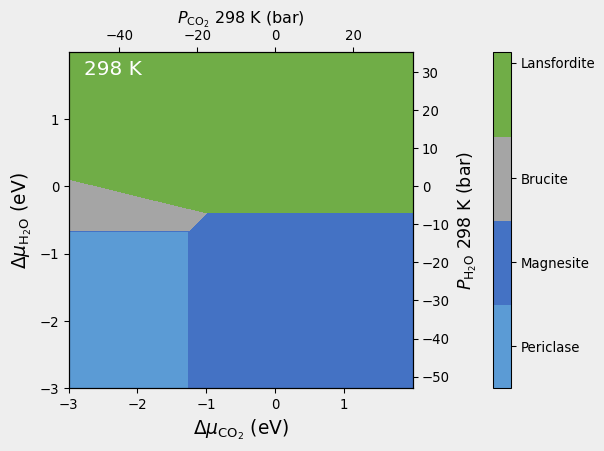

In [20]:
system, c = calculate(data, bulk, deltaX, deltaY, x_energy, y_energy)

system.plot_mu_p(temperature=298)

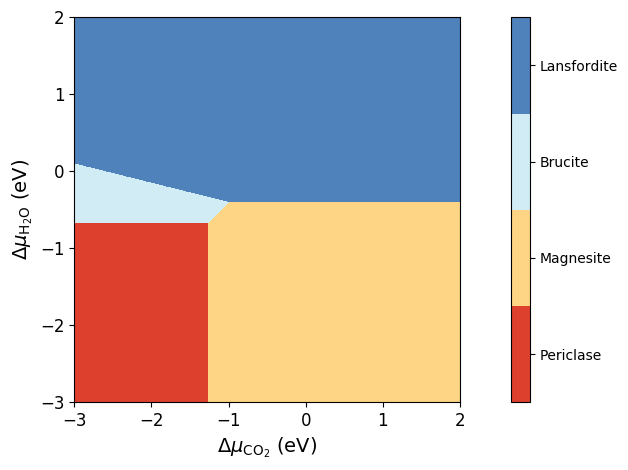

In [20]:
Zero_K = calculate(data, bulk, deltaX, deltaY, x_energy, y_energy)
Zero_K.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")

In [21]:
CO2_exp = temperature_correction("CO2.txt", 298)
Water_exp = temperature_correction("H2O.txt", 298)

CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -1, 0.6],  'Label': 'CO_2'}
deltaY = {'Range': [ -1, 0.6], 'Label': 'H_2O'}

In [22]:
print(Water_exp)
print(CO2_exp)


-0.4803821521773276
-0.5630374282399562


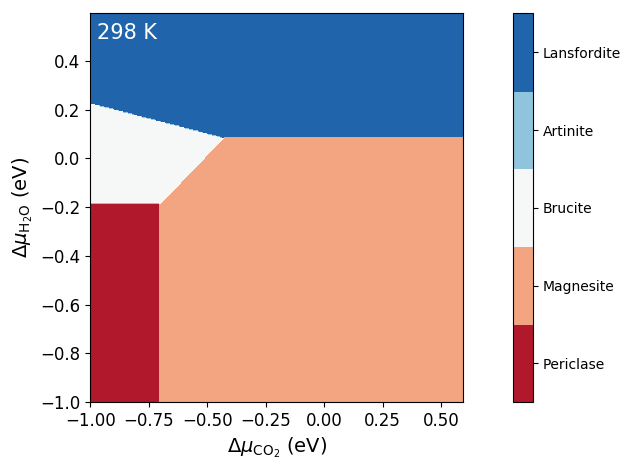

In [23]:
temp_298 = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_phase(temperature=298, set_style="fast", colourmap="RdBu")

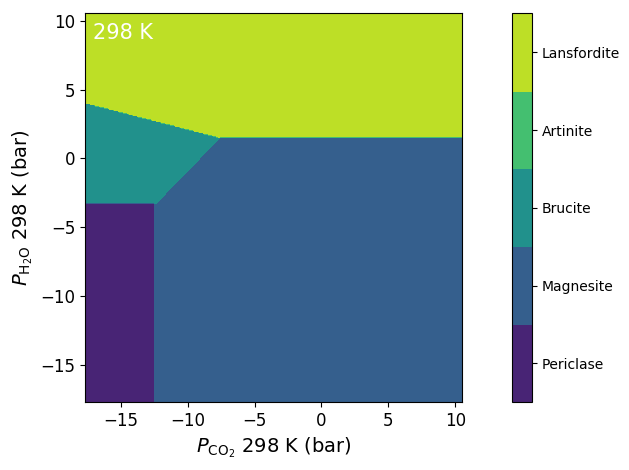

In [24]:
temp_298.plot_pressure(temperature=298)

# P-defect Example

In [16]:
bulk = {'Cation' : 1, 'Anion' : 0, 'Energy' : -1015.70, 'F-Units' : 27}
    

In [17]:
PO4 =     {'Cation': 27, 'X': 0.5, 'Y': -2.25, 'Energy': -993.11,   'Label': 'PO_4'}
PO5 =      {'Cation': 27, 'X': 0.5, 'Y': -1.75, 'Energy': -1002.5226,   'Label': 'PO_5'}
PO6 =    {'Cation': 27, 'X': 0.5, 'Y': -1.25, 'Energy': -1010.5135,   'Label': 'PO_6'}


In [18]:
data = [PO4, PO5, PO6]

In [19]:
deltaX = {'Range': [ -30, 20],  'Label': 'P2O5'}
deltaY = {'Range': [ -30, 20], 'Label': 'O2'}
x_energy=-49.18
y_energy=-9.88

In [ ]:
system = calculate(data, bulk, deltaX, deltaY, x_energy, y_energy)
system.plot_phase()

In [20]:
O2_exp = temperature_correction("O2.txt", 298)
P2O5_exp = temperature_correction("P2O5.txt", 298)

O2_corrected = x_energy + O2_exp
P2O5_corrected = y_energy + P2O5_exp
deltaX = {'Range': [ -7, 5],  'Label': 'P_2O_5'}
deltaY = {'Range': [ -7, 5], 'Label': 'O_2'}

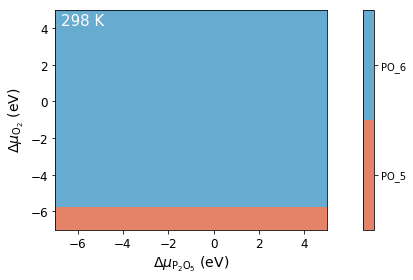

In [24]:
temp_298 = calculate(data, bulk, deltaX, deltaY, O2_corrected, P2O5_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_phase(temperature=298, set_style="fast", colourmap="RdBu")

# UO2 Example

In [77]:
bulk = {'Cation' : 1, 'Anion' : 0, 'Energy' : -938.76867296, 'F-Units' : 32}

In [78]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Y': 0, 'Energy': -938.76867296,   'Label': 'U32O64H0'}
U32O64H1 =     {'Cation': 32, 'X': 0, 'Y': 0.5, 'Energy': -941.9498006,   'Label': 'U32O64H1'}
U32O64H2 =      {'Cation': 32, 'X': 0, 'Y': 1, 'Energy': -946.0943744,   'Label': 'U32O64H2'}
U32O63H0 =    {'Cation': 32, 'X': -0.5, 'Y': 0, 'Energy': -928.0471514,   'Label': 'U32O63H0'}
U32O63H1 =     {'Cation': 32, 'X': -0.5, 'Y': 0.5, 'Energy': -934.3267507,   'Label': 'U32O63H1'}
U32O63H2 =      {'Cation': 32, 'X': -0.5, 'Y': 1, 'Energy': -936.1826208,   'Label': 'U32O63H2'}
U32O65H0 =    {'Cation': 32, 'X': 0.5, 'Y': 0, 'Energy': -944.9309093,   'Label': 'U32O65H0'}
U32O65H1 =     {'Cation': 32, 'X': 0.5, 'Y': 0.5, 'Energy': -949.1422805,   'Label': 'U32O65H1'}
U32O65H2 =      {'Cation': 32, 'X': 0.5, 'Y': 1, 'Energy': -952.0880799,   'Label': 'U32O65H2'}

In [79]:
data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

In [80]:
deltaX = {'Range': [ -30, 20],  'Label': 'O2'}
deltaY = {'Range': [ -30, 20], 'Label': 'H2'}
x_energy=-9.883704
y_energy=-6.771542

In [81]:
O2_exp = temperature_correction("O2.txt", 298)
H2_exp = temperature_correction("H2.txt", 298)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

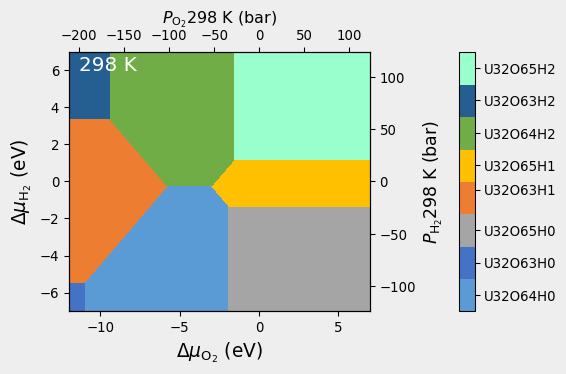

In [82]:
temp_298, c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_mu_p(temperature=298, set_style="fast", colourmap="RdBu", output="298_All_mvm")

In [83]:
O2_exp = temperature_correction("O2.txt", 427)
H2_exp = temperature_correction("H2.txt", 427)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

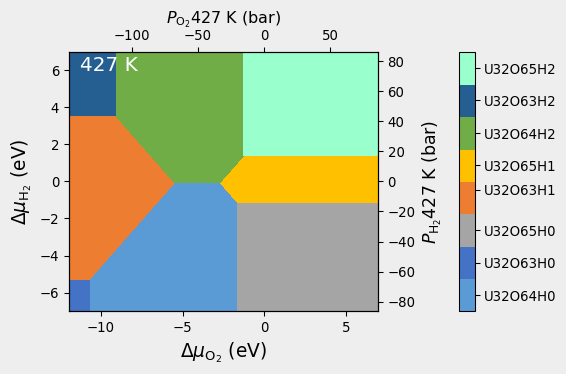

In [84]:
temp_427,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_427.plot_mu_p(temperature=427, set_style="fast", colourmap="RdBu", output="427_All_mvm")

In [85]:
O2_exp = temperature_correction("O2.txt", 1427)
H2_exp = temperature_correction("H2.txt", 1427)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

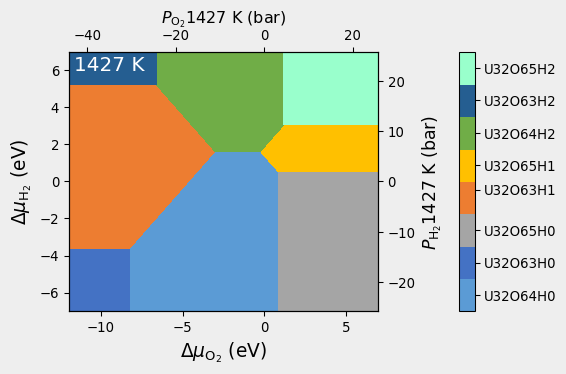

In [86]:
temp_1427,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_1427.plot_mu_p(temperature=1427, set_style="fast", colourmap="RdBu", output="1427_All_mvm")

In [87]:
O2_exp = temperature_correction("O2.txt", 2900)
H2_exp = temperature_correction("H2.txt", 2900)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

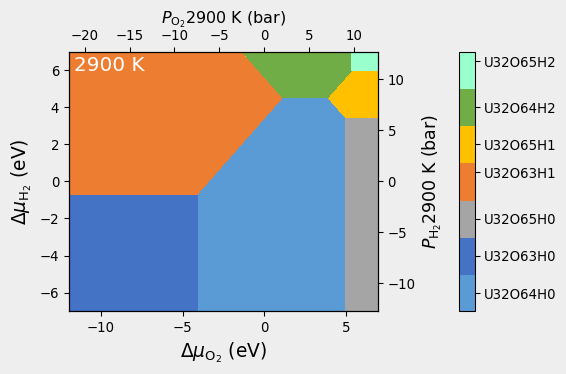

In [88]:
temp_2900,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_2900.plot_mu_p(temperature=2900, set_style="fast", colourmap="RdBu", output="2900_All_mvm")

No bulk phases

In [89]:
U32O64H0 =     {'Cation': 32, 'X': 0, 'Y': 0, 'Energy': 1000000,   'Label': 'U32O64H0'}

data = [U32O64H0, U32O64H1, U32O64H2, U32O63H0, U32O63H1,  U32O63H2, U32O65H0, U32O65H1, U32O65H2]

In [90]:
O2_exp = temperature_correction("O2.txt", 298)
H2_exp = temperature_correction("H2.txt", 298)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

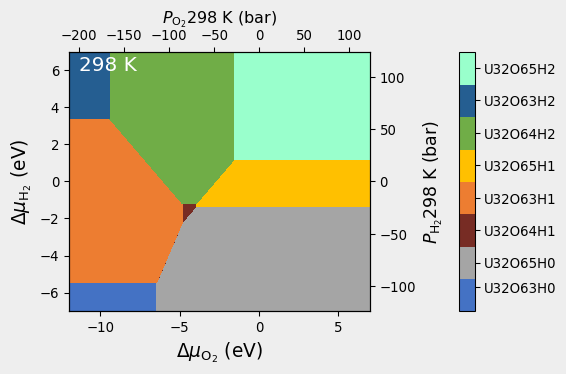

In [91]:
temp_298,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_mu_p(temperature=298, set_style="fast", colourmap="RdBu", output="298_NoBulk_mvm")

In [92]:
O2_exp = temperature_correction("O2.txt", 427)
H2_exp = temperature_correction("H2.txt", 427)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

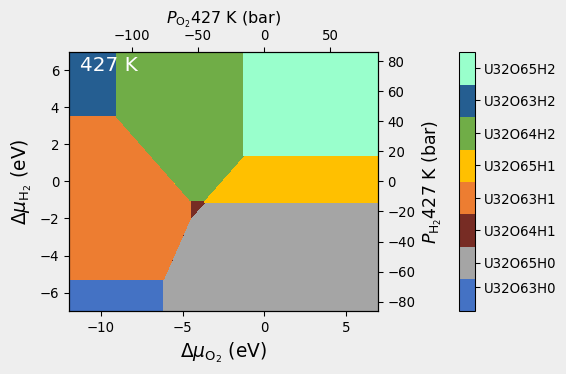

In [93]:
temp_427,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_427.plot_mu_p(temperature=427, set_style="fast", colourmap="RdBu", output="427_NoBulk_mvm")

In [94]:
O2_exp = temperature_correction("O2.txt", 1427)
H2_exp = temperature_correction("H2.txt", 1427)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp

deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

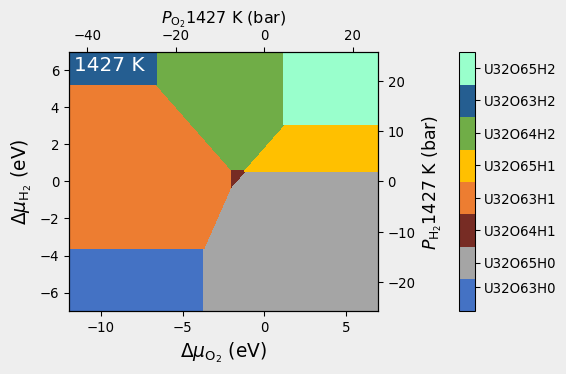

In [95]:
temp_1427,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_1427.plot_mu_p(temperature=1427, set_style="fast", colourmap="RdBu", output="1427_NoBulk_mvm")

In [96]:
O2_exp = temperature_correction("O2.txt", 2900)
H2_exp = temperature_correction("H2.txt", 2900)

O2_corrected = x_energy + O2_exp
H2_corrected = y_energy + H2_exp


deltaX = {'Range': [ -12, 7],  'Label': 'O_2'}
deltaY = {'Range': [ -7, 7], 'Label': 'H_2'}

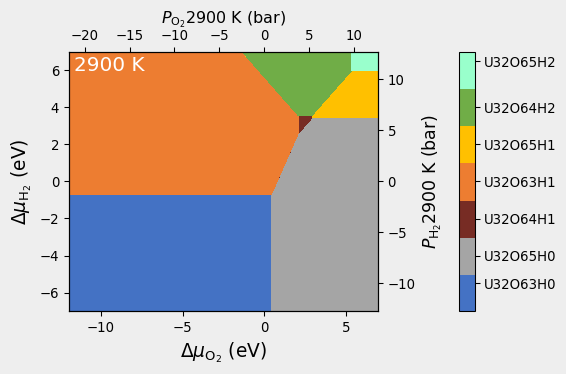

In [97]:
temp_2900,c = calculate(data, bulk, deltaX, deltaY, O2_corrected, H2_corrected)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_2900.plot_mu_p(temperature=2900, set_style="fast", colourmap="RdBu", output="2900_NoBulk_mvm")

# Solid Entropy Examples

In [43]:
bulk = {'Cation' : 1, 'Anion' : 1, 'Energy' : -92.35637426, 'F-Units' : 10, 'File-Name': 'bulk_vib.yaml'}

In [44]:
MgO = {'Cation': 10, 'X': 0, 'Y': 0, 'Energy': -92.35637426,   'Label': 'Periclase', 'File-Name': 'MgO_vib.yaml', 'F-Units': 10}
Art = {'Cation': 10, 'X': 5, 'Y': 20, 'Energy': -467.308589,   'Label': 'Artinite', 'File-Name': 'Art_vib.yaml', 'F-Units': 5}
Bru = {'Cation': 10, 'X': 0, 'Y': 10, 'Energy': -227.3449021,   'Label': 'Brucite', 'File-Name': 'Bru_vib.yaml', 'F-Units': 10}
Nes = {'Cation': 10, 'X': 10, 'Y': 30, 'Energy': -705.7643942,   'Label': 'Nesquehonite', 'File-Name': 'Nes_vib.yaml', 'F-Units': 10}
Mag = {'Cation': 10, 'X': 10, 'Y': 0, 'Energy': -310.3283693,   'Label': 'Magnesite', 'File-Name': 'Mag_vib.yaml', 'F-Units': 10}
Lan = {'Cation': 10, 'X': 10, 'Y': 50, 'Energy': -971.8116011,  'Label': 'Lansfordite', 'File-Name': 'Lan_vib.yaml', 'F-Units': 10}
Hyd = {'Cation': 10, 'X': 8, 'Y': 10, 'Energy': -398.6071433,  'Label': 'Hydromagnesite', 'File-Name': 'Hyd_vib.yaml', 'F-Units': 2}

In [45]:
data = [MgO, Art, Bru, Nes,  Mag, Lan, Hyd]

In [46]:
deltaX = {'Range': [ -3, 2],  'Label': 'CO_2'}
deltaY = {'Range': [ -3, 2], 'Label': 'H_2O'}
x_energy=-20.53412969
y_energy=-12.83725889

In [47]:
Entropy_true = True
ZPE_true = False

temp_range = {'Range': [298,299], 'Label': 'Temperature'}


In [48]:
CO2_exp = temperature_correction("CO2.txt", 298)
Water_exp = temperature_correction("H2O.txt", 298)

print(CO2_exp, Water_exp)

# CO2_exp = -0.660309811
# Water_exp = -0.583027356


CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -1, 0.6],  'Label': 'CO_2'}
deltaY = {'Range': [ -1, 0.6], 'Label': 'H_2O'}

-0.5630374282399562 -0.4803821521773276


<ipython-input-36-e2a4dded0743>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vib_prop = yaml.load(file)


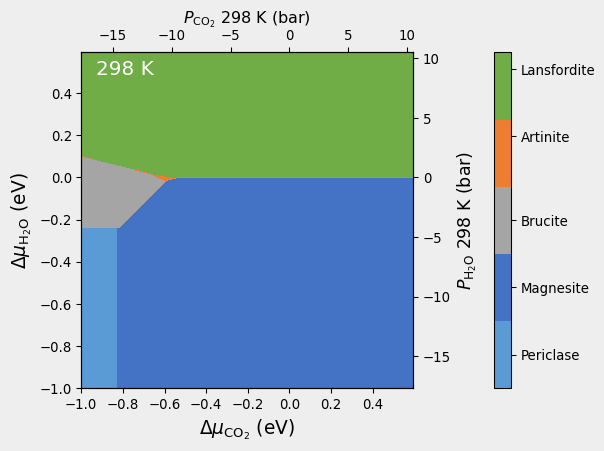

In [50]:
temp_298,c = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected, Entropy_true, ZPE_true, temp_range)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_mu_p(temperature=298, set_style="fast", colourmap="RdBu")

In [53]:
data = [MgO, Bru, Mag]

In [54]:
CO2_exp = temperature_correction("CO2.txt", 298)
Water_exp = temperature_correction("H2O.txt", 298)

print(CO2_exp, Water_exp)

# CO2_exp = -0.660309811
# Water_exp = -0.583027356


CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -3, 2],  'Label': 'CO_2'}
deltaY = {'Range': [ -3, 2], 'Label': 'H_2O'}

-0.5630374282399562 -0.4803821521773276


<ipython-input-36-e2a4dded0743>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vib_prop = yaml.load(file)


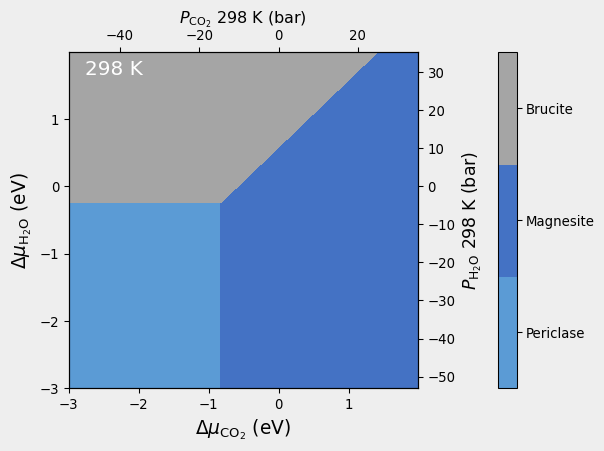

In [55]:
temp_298,c = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected, Entropy_true, ZPE_true, temp_range)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_mu_p(temperature=298, set_style="fast", colourmap="RdBu")

In [36]:
MgO = {'Cation': 10, 'X': 0, 'Y': 0, 'Energy': -91.82190186,   'Label': 'Periclase', 'File-Name': 'MgO_vib.yaml', 'F-Units': 10}
Bru = {'Cation': 10, 'X': 0, 'Y': 10, 'Energy': -225.9849449,   'Label': 'Brucite', 'File-Name': 'Bru_vib.yaml', 'F-Units': 10}
Mag = {'Cation': 10, 'X': 10, 'Y': 0, 'Energy': -309.1173889,   'Label': 'Magnesite', 'File-Name': 'Mag_vib.yaml', 'F-Units': 10}


In [37]:
data = [MgO, Bru, Mag]

In [38]:
CO2_exp = temperature_correction("CO2.txt", 298)
Water_exp = temperature_correction("H2O.txt", 298)

print(CO2_exp, Water_exp)

# CO2_exp = -0.660309811
# Water_exp = -0.583027356


CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -3, 2],  'Label': 'CO_2'}
deltaY = {'Range': [ -3, 2], 'Label': 'H_2O'}

-0.5630374282399562 -0.4803821521773276


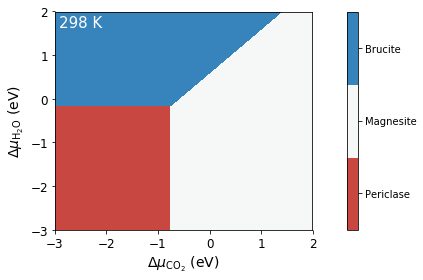

In [39]:
temp_298 = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected, Entropy_true, ZPE_true, temp_range)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_phase(temperature=298, set_style="fast", colourmap="RdBu")

In [40]:
CO2_exp = -0.660309811
Water_exp = -0.583027356


CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -1, 0.6],  'Label': 'CO_2'}
deltaY = {'Range': [ -1, 0.6], 'Label': 'H_2O'}

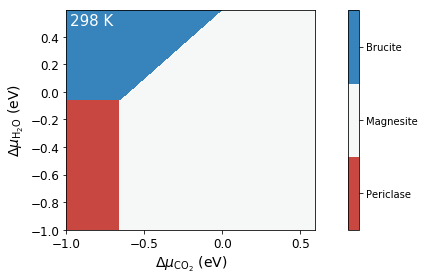

In [41]:
temp_298 = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected, Entropy_true, ZPE_true, temp_range)
#temp_298.plot_phase(output="seaborn_rdybu.png", set_style="seaborn-dark-palette", colourmap="RdYlBu")
temp_298.plot_phase(temperature=298, set_style="fast", colourmap="RdBu")